<div align="Right">
https://github.com/mrola/blacklist_overlap_test<br>
</div>

# Preliminaries

The purpose of this Jupyter notebook is to provide a measure on the degree to which blacklists overlap in terms of IPv4 entries. The notebook extract IPv4 addresses from public and private blacklists and then provides a barchart showing sizes per blacklist and a heatmap showing the degree of overlap between the blacklists. 

The URLs of the public blacklists as well as the path to the local blacklist files are set within the notebook.

The data frame that that contains all ip addresses entries for every blacklist/source may be saved in a csv format.

This project is inspired by the combine and tiq-test project (written in R) by [@alexpc](https://twitter.com/alexcpsec), [@kylemaxwell](https://twitter.com/kylemaxwell) and others. While the tiq-test project provides additional quality metrics and also supports enrichment, this notebook is pure Python and at this point only provides the overlap test. That said, if overlap test is the goal then just running this Jupyter notebook will do the fetch data, extract IP addresses, calculate overlap between each pair, build heatmap steps and save data for further research. The notebook is designed to be standalone.

References:
* https://github.com/mlsecproject/combine
* https://github.com/mlsecproject/tiq-test
* http://rpubs.com/alexcpsec/tiq-test-Winter2015


### Requirements

* Python >= 2.7 <small>(tested with 2.7 and 3.4)</small>
* Pandas > 0.16 <small>(tested with 0.16 and 0.18)</small>
    * http://pandas.pydata.org/pandas-docs/stable/index.html
    * https://github.com/pydata/pandas
* Seaborn >= 0.6.0 <small>(tested with 0.6.0 and 0.7.0)</small>
    * http://stanford.edu/~mwaskom/software/seaborn/
    * https://github.com/mwaskom/seaborn
* Requests > 2.5 <small>(tested with 2.5.3 and 2.9.0)</small>
    * http://docs.python-requests.org/en/latest/
    * https://github.com/kennethreitz/requests
* Jupyter Notebook > 4.0: <small>(only tested with 4.0.6 but may work with older versions)</small>
    * https://github.com/jupyter/notebook

----
If the above requirements are not met then installing miniconda is probably the simplest and fastest way to get ahead. Conda will allow you to create a local "environment" that contains all the necessary packages with all dependencies met without interfering with any global Python installation

>*Conda is a cross-platform and Python-agnostic package manager and environment manager program that quickly   installs, runs and updates packages and their dependencies and easily creates, saves, loads and switches   between environments on your local computer. Conda is included in all versions of Anaconda, Miniconda and Anaconda Server.*

Reference: http://conda.pydata.org/miniconda.html



## Import libraries

In [1]:
import os
import re
import sys
import time
import socket
import platform
import itertools
import requests as req

import logging
from imp import reload

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt

%matplotlib inline

### Print versions

In [2]:
print('\nPython version: %s' % platform.python_version())
print('Pandas version: %s' % pd.__version__)
print('Matplotlib version: %s' % mpl.__version__)
print('Seaborn version: %s' % sns.__version__)
print('Requests version: %s' % req.__version__)


Python version: 3.4.4
Pandas version: 0.18.1
Matplotlib version: 1.5.1
Seaborn version: 0.7.0
Requests version: 2.9.1


## Defaults

### Set date and base paths

In [3]:
# Today is used as date unless DATE is set here, format"YYYY-MM-DD"
DATE = None

# If True, save data to DIR_OUTPOUT_* as defined below
SAVE = True

# GET_URLS=True means that ioc data is fetched from public/internet sources, see inbound URLs section
GET_URLS = True

# READ_PREFETCH=True means that ioc data is fetched from private/local files, see Prefetched section
READ_PREFETCH = False

# TIMEOUT - number of seconds Requests will wait for a response from the server (both connect and between reads)
TIMEOUT = 4

# ANNOTATE - Set to True if actual value should be written in each heatmap cell
ANNOTATE=True

# Paths
datadir = os.getcwd() + '/../data/'
DIR_OUTPUT_URL = datadir + 'public_inbound/output/'
DIR_OUTPUT_PREFETCHED = datadir + 'private_inbound/output/'
DIR_INPUT_PREFETCHED = datadir + 'private_inbound/input/'


## Set log level

In [4]:
# Set level to one of DEBUG, INFO, WARNING, ERROR

reload(logging)
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(name)-4s: %(levelname)-2s %(message)s', \
                    datefmt='%Y-%m-%d %H:%M:%S', stream=sys.stdout)

### Set URLs and file paths

#### Inbound URLs

In [5]:
# Key: Description of source.
# Value: URL to be fetched

inbound_urls = {
    'badips.http':                       'https://www.badips.com/get/list/http/3?age=2w',
    'badips.postfix':                    'https://www.badips.com/get/list/postfix/3?age=2w',
    'badips.ssh':                        'https://www.badips.com/get/list/ssh/3?age=2w',
    'openbl.base':                       'http://www.openbl.org/lists/base.txt',
    'malwaredomainlist.hostslist':       'http://www.malwaredomainlist.com/hostslist/ip.txt',
    'malc0de.ip_blacklist':              'http://malc0de.com/bl/IP_Blacklist.txt',
    'blocklist.all':                     'http://lists.blocklist.de/lists/all.txt',
    'spamhaus.drop':                     'http://www.spamhaus.org/drop/drop.txt',
    'spamhaus.edrop':                    'https://www.spamhaus.org/drop/edrop.txt',
    'emergingthreats.compromised':       'http://rules.emergingthreats.net/blockrules/compromised-ips.txt',
    'emergingthreats.emerging':          'http://rules.emergingthreats.net/fwrules/emerging-Block-IPs.txt',
    'palevotracker.ipblocklist':         'https://palevotracker.abuse.ch/blocklists.php?download=ipblocklist',
    'feodotracker.ipblocklist':          'https://feodotracker.abuse.ch/blocklist/?download=ipblocklist',
    'feodotracker.badips':               'https://feodotracker.abuse.ch/blocklist/?download=badips',
    'blutmagie.tor.exit':                'http://torstatus.blutmagie.de/ip_list_exit.php/Tor_ip_list_EXIT.csv',
    'blutmagie.tor.all':                 'http://torstatus.blutmagie.de/ip_list_all.php/Tor_ip_list_ALL.csv',
    'dan.me.torlist':                    'https://www.dan.me.uk/torlist/',
    'malcode.database':                  'http://malc0de.com/database/',
    'autoshun.shunlist':                 'http://www.autoshun.org/files/shunlist.csv',
    'rulez.blist':                       'http://danger.rulez.sk/projects/bruteforceblocker/blist.php',
    'dragonresearch.vnc':                'https://www.dragonresearchgroup.org/insight/vncprobe.txt',
    'dragonresearhc.http':               'https://www.dragonresearchgroup.org/insight/http-report.txt',
    'dragonresearch.ssh':                'https://www.dragonresearchgroup.org/insight/sshpwauth.txt',
    'alienvault.generic':                'https://reputation.alienvault.com/reputation.generic',
    'sslbl.sslipblacklist':              'https://sslbl.abuse.ch/blacklist/sslipblacklist.csv',
    'zeustracker.badips':                'https://zeustracker.abuse.ch/blocklist.php?download=badips'
}

inbound_urls_test = {
    'badips.ssh':                        'https://www.badips.com/get/list/ssh/3?age=2w',
    'rulez.blist':                       'http://danger.rulez.sk/projects/bruteforceblocker/blist.php',
    'malwaredomainlist_ip.txt':          'http://www.malwaredomainlist.com/hostslist/ip.txt',
    'malcode.database':                  'http://malc0de.com/database/'
}

#### Prefetched

In [6]:
# Key: Local file to be read
# Value: Description of source.
#
# Example entries, zeus_ipblocklist.ioc:
#  101.0.89.3,zeustracker
#  101.200.81.187,zeustracker


inbound_prefetched = {
    DIR_INPUT_PREFETCHED + 'compromised-ips.ioc':       'compromised-ips.ioc',
    DIR_INPUT_PREFETCHED + 'ips.ioc':                   'ips.ioc',
    DIR_INPUT_PREFETCHED + 'zeus_ipblocklist.ioc':      'zeus_ipblocklist.ioc'
}

inbound_prefetched_test = {
    DIR_INPUT_PREFETCHED + 'compromised-ips.ioc':       'compromised-ips.ioc',
    DIR_INPUT_PREFETCHED + 'compromised-ips_test.ioc':  'compromised-ips_test.ioc',
    DIR_INPUT_PREFETCHED + 'zeus_ipblocklist.ioc':      'zeus_ipblocklist.ioc',
    DIR_INPUT_PREFETCHED + 'zeus_ipblocklist_test.ioc': 'zeus_ipblocklist_test.ioc'
}


#### Plot and display options

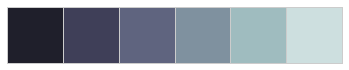

In [7]:
# Pandas - global display options
pd.set_option('display.width', 120)
pd.set_option('max_colwidth', 0)

# Seaborn - plot options
sns.set()
sns.set(style="whitegrid", rc={"figure.figsize": (14, 8)})
sns.set_palette("bone")
sns.palplot(sns.color_palette())

# Functions

In [8]:
def set_date():
    if DATE:
        return DATE    
    else:
        return(time.strftime("%Y-%m-%d"))

In [9]:
# do_pandas()
# Takes a list of IPv4 addresses as input and stores those in a Pandas DataFrame
#
# DataFrame columns: "entity","type","direction","source","notes","date"
# "1.234.27.146","IPv4","inbound","http://malc0de.com/bl/IP_Blacklist.txt","","2016-01-27
#
# DATE is set to today, override this in Defaults section above if needed

def do_pandas(df, ips, name):
    df_ips = pd.DataFrame()
    date = set_date()

    tup = (ips, 'IPv4', 'inbound',name, "", date)
    (df_ips['entity'], df_ips['type'], df_ips['direction'], \
         df_ips['source'], df_ips['notes'], df_ips['date']) = tup 
    df = df.append(df_ips, ignore_index=True)
    return df


In [10]:
# valid_ip()
# Checks if an IPv4 address is valid

def valid_ip(address):
    logger = logging.getLogger('valid_ip')
    try: 
        socket.inet_aton(address)
    except:
        logger.warning("Invalid address: %s" % address)
        return False
    return True


In [11]:
# parse_content()
# Extract IPv4 address from a list of rows

ipv4 = re.compile("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}")

def parse_content(source):
    logger = logging.getLogger('parse_content')
    ips = []
    for line in source:
        try:
            m = re.search(ipv4, line.decode('utf-8'))
            if m:
                address = m.group(0)
                if valid_ip(address):
                     ips.append(address)
        except UnicodeDecodeError as e:
            logger.warning("utf-8 decode failure. Skipping line...")
            pass
        except Exception as e:
            logger.error("Unexpected exception. Skipping line. %s" % e)
            pass
    if ips:
        return ips
    else:
        return False
    

In [12]:
# get_url()
# Uses the request library to GET URLs defined in the "inbound_urls" dictionary.


def get_url(urls, df):
    logger = logging.getLogger('get_url')
    fail_count = 0
    for name, url in iter(urls.items()):
        logger.info('Fetching: %s' % url)
        try:
            r = req.get(url, timeout=TIMEOUT, headers={'User-Agent': 'Mozilla/5.0'})
            if r.status_code == 200:
                logger.debug('Got status 200 back...')
                ips = parse_content(r.content.splitlines())
                if ips:
                    df = do_pandas(df, ips, name)
                elif ips is False:
                    logger.warning('Found no valid ipv4 addresses.')
            else:
                logger.warning ('Got status %d' % r.status_code)
        except req.ConnectionError as e:            
            logger.error('Failed to fetch url due connectivity issues.')
            logger.error('%s' % e)
            fail_count += 1
            if fail_count > 2:
                logger.error('\nConnectivity issues assumed to be permanent. Will abort.')
                break
        except Exception as e:
            logger.error('Failed to fetch url.\nError msg: %s' % e)
    return df


In [13]:
# get_prefetched()
# Read files defined in the "inbound_prefetched" dictionary.

def get_prefetched(files, df):
    logger = logging.getLogger('get_prefetched')
    dflist = []
    logger.info('Reading data...')
    for filen, description in iter(files.items()):
        if not os.path.exists(filen): 
            logger.warning('Failed to read data from:\n\t%s...' % os.path.relpath(filen)) 
        else:
            try: 
                logger.info('%s' % os.path.relpath(filen)) 
                with open(filen, 'rb') as f:
                    ips = parse_content(f.readlines())
                    if ips:
                        df = do_pandas(df, ips, description)
                    else:
                        logger.warning('Failed to find valid entries.')
            except Exception as e:
                logger.error('Caught exception: %s\nAbort...' % e)
                break
    return df


In [14]:
# fill_heatmap()
# Calculate proportion of items in intersection between two blacklists to each blacklist per se. 
#  dfp: contains data for calculations. 
#  df_heat: put results in this frame.
#  cols: pair of columns (blacklists) used as input to calculations.

def fill_heatmap(cols, dfp, df_heat):
    s = dfp.eq(dfp[cols[0]], axis='index')[cols].all(1)
    common = s[s.values == True].count()
    
    col0_sum = dfp[cols[0]].sum()
    col1_sum = dfp[cols[1]].sum()
    
    df_heat[cols[0]].loc[cols[1]] = common/col0_sum
    df_heat[cols[1]].loc[cols[0]] = common/col1_sum
    

In [15]:
# do_heatframes()
# Create frames used in calculation of overlap.
#  dfp: DataFrame with ipv4 as index and blacklist as columns. Used to find entries in common
#  df_heat: DataFrame that will contain the actual overlap values
#  colpairs: list of 2-tuples where each tuple contains a unique pair of blacklists

def do_heatframes(df):
    df['one'] = 1
    dfp = pd.pivot_table(df, values='one', index=['entity'], columns=['source'])
    
    df_heat = pd.DataFrame({'contains': pd.unique(df.source), 'is contained': pd.unique(df.source)})
    df_heat['diag'] = 1
    df_heat = df_heat.pivot('contains','is contained', 'diag')
    
    colpairs = itertools.combinations(pd.unique(df.source), 2)
    for colpair in colpairs:
        fill_heatmap(list(colpair), dfp, df_heat)

    return df_heat


In [16]:
# plot_counts()
# Barchart showing size of each blacklist feed

def plot_counts(df):
    gby = df.groupby(["source"])
    s = gby.size().sort_values(ascending=False)   
    sns.set(style="whitegrid", font_scale=1.0, rc={"figure.figsize": (14, 4)})
    ax = sns.barplot(orient='h', x=s, y=s.index, palette="bone")
#    ax = sns.countplot(y="source", data=df.sort_index(axis=1, ascending=False), palette="bone");
    ax.set(title="Barplot showing the count of entries per source - %s\n" % (set_date()));
    plt.show()
    

In [17]:
# plot_heat()
# Heatmap showing the overlap between blacklist feeds

def plot_heat(df):
    df_heat = do_heatframes(df)
    sns.set(style="whitegrid", font_scale=1.0, rc={"figure.figsize": (14, 4)})
    asize = None
    if df_heat.shape[0] > 10:
        asize = {'size': 7}
    ax = sns.heatmap(df_heat, linewidths=.5, annot_kws=asize, annot=ANNOTATE, cmap="bone");
    ax.set(title="Overlap test - heatmap showing overlap between blacklists - %s\n" % (set_date()))
    plt.xticks(rotation=40, horizontalalignment='right');
    plt.show()
    

In [18]:
# show_info()
# Print some info to verify result.

def show_info(df):
    logger = logging.getLogger('show_info')
    logger.info('>>General info to verify everything is ok <<')
    logger.info('\n\nVerify we got all sources:\n%s\n' % pd.Series(pd.unique(df.source)))
    logger.info('First few frame rows:\n%s\n' % df.head())
    logger.info('Frame contains %d entries.\n\n' % df.shape[0])
    

In [19]:
# save_frame()
# Write to .csv

def save_frame(df, path):
    logger = logging.getLogger('save_frame')
    date = set_date()
    udate = date.replace('-', '')
    savepath = path + udate + '.csv'
    if not os.path.exists(path):
        logger.warning("Failed to find path: %s" % path)
        logger.info("Setting path to '/tmp/'")
        savepath = '/tmp/' + udate + '.csv'
    logger.info("Attempting to save frame...")
    try:
        df.to_csv(savepath, index=False)
        logger.info("Successfully saved frame to:\n\t%s" % os.path.relpath(savepath))
    except Exception as e:
        logger.error("%s\n" % e)
            

In [20]:
# wrapitup()
# 

def wrapitup(df, dir_output):
    logger = logging.getLogger('wrapitup')
    if df.values.size > 0:
        show_info(df)
        plot_counts(df)
        if (len(pd.unique(df.source)) > 1):
            print("\n\n")
            plot_heat(df)
        else:
            logger.info("Only got a single blacklist feed. No overlap to display.")
        if SAVE:
            save_frame(df, dir_output)
    else:
        logger.warning("Got empty data frame...")
    
    print('\nDone!\n\n')


In [21]:
# main()
# 

def main():
    logger = logging.getLogger('main')
    cols = ["entity","type","direction","source","notes","date"]
    
    if GET_URLS:
        print("\n\n>>>> Fetching public inbound blacklisted IPv4 addresses from URLs <<<<\n")
        df = pd.DataFrame(columns=cols)
        df = get_url(inbound_urls, df)
        wrapitup(df, DIR_OUTPUT_URL)
        
    if READ_PREFETCH:
        print("\n\n>>>> Fetching private inbound blacklisted IPv4 addresses from disk <<<<\n")
        df = pd.DataFrame(columns=cols)
        df = get_prefetched(inbound_prefetched, df)
        wrapitup(df, DIR_OUTPUT_PREFETCHED)
        



>>>> Fetching public inbound blacklisted IPv4 addresses from URLs <<<<

2016-06-21 14:42:29 get_url: INFO Fetching: http://malc0de.com/database/
2016-06-21 14:42:30 get_url: INFO Fetching: http://www.autoshun.org/files/shunlist.csv
2016-06-21 14:42:31 get_url: INFO Fetching: https://www.dragonresearchgroup.org/insight/vncprobe.txt
2016-06-21 14:42:32 get_url: INFO Fetching: https://www.dan.me.uk/torlist/
2016-06-21 14:42:33 get_url: WARNING Got status 403
2016-06-21 14:42:33 get_url: INFO Fetching: http://danger.rulez.sk/projects/bruteforceblocker/blist.php
2016-06-21 14:42:35 get_url: INFO Fetching: http://torstatus.blutmagie.de/ip_list_all.php/Tor_ip_list_ALL.csv
2016-06-21 14:42:36 get_url: INFO Fetching: http://malc0de.com/bl/IP_Blacklist.txt
2016-06-21 14:42:36 get_url: INFO Fetching: https://zeustracker.abuse.ch/blocklist.php?download=badips
2016-06-21 14:42:37 get_url: INFO Fetching: https://reputation.alienvault.com/reputation.generic
2016-06-21 14:42:40 get_url: INFO Fetchin

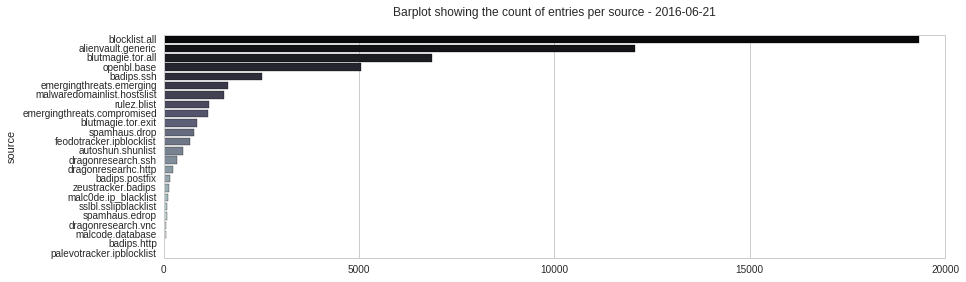

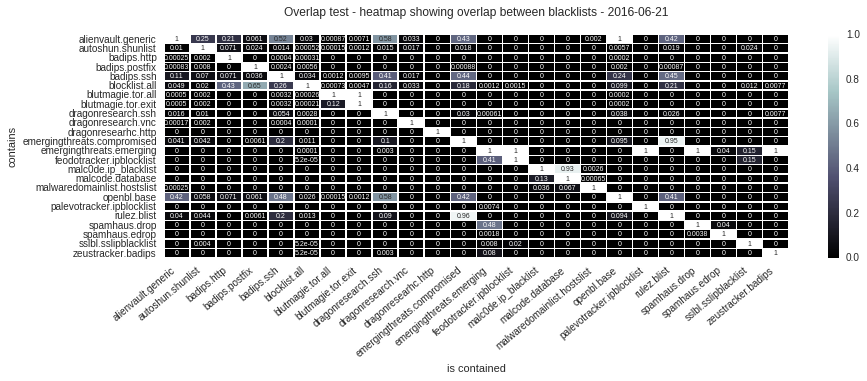

2016-06-21 14:43:01 save_frame: INFO Attempting to save frame...
2016-06-21 14:43:02 save_frame: INFO Successfully saved frame to:
	../data/public_inbound/output/20160621.csv

Done!




In [22]:
main()